# Repetition code

In [2]:
import stim
import numpy as np
import torch
from pymatching import Matching
from os.path import abspath, dirname, exists

def count_logical_errors(detector_error_model, detection_events, observable_flips):
    # Sample the circuit.
    num_shots = detection_events.shape[0]
    matcher = Matching.from_detector_error_model(detector_error_model)

    # Run the decoder.
    predictions = matcher.decode_batch(detection_events).squeeze()
    # Count the mistakes.
    num_errors = 0
    for shot in range(num_shots):
        actual_for_shot = observable_flips[shot][0]
        predicted_for_shot = predictions[shot]
        # print(actual_for_shot, predicted_for_shot)
        if not np.array_equal(actual_for_shot, predicted_for_shot):
            num_errors += 1
    return num_errors


def forward(n_s, m, van, syndrome, device, dtype, k=1):
    condition = syndrome*2-1
    x = (van.partial_forward(n_s=n_s, condition=condition, device=device, dtype=dtype, k=k) + 1)/2
    # print(x)
    x = x[:, m:m+int(2*k)]
    # print(x)
    return x

d, r, k = 17, 1, 1
ert = 0.1
trials = 10000
a = 100
dtype = torch.float32
device = 'cuda:3'

path = abspath(dirname('result'))+'/decoding/net/cir/'+'rep_d{}_r{}_k{}_er{}a.pt'.format(d, r, k, ert)
van = torch.load(path).to(device).to(dtype)

ers = np.linspace(0.1, 0.12, 3)#[0.08]



ls = np.zeros((a, len(ers)))
lmws = np.zeros((a, len(ers)))


for j in range(a):
    for i in range(len(ers)):
        er = ers[i]
        circuit = stim.Circuit.generated(code_task="repetition_code:memory",
                                            distance=d,
                                            rounds=r,
                                            after_clifford_depolarization=er,
                                            before_measure_flip_probability=er,
                                            after_reset_flip_probability=er,
                                            )

        dem = circuit.detector_error_model(decompose_errors=False, flatten_loops=True)

        sampler = circuit.compile_detector_sampler(seed=j)#721*j+int(100*er)
        dets0, obvs0 = sampler.sample(shots=trials, separate_observables=True)
        lmw = count_logical_errors(detector_error_model=dem, detection_events=dets0, observable_flips=obvs0*1)/trials
        lmws[j, i] = lmw

        lconf = forward(n_s=trials, m=(d-1)*(r+1), van=van, syndrome=torch.tensor(dets0)*1.0, device=device, dtype=dtype, k=k/2)
        # print(lconf[0])
        aclo = (torch.tensor(obvs0)*1.0).to(device).to(dtype)
        # print(aclo[0])
        logical_error_rate = torch.count_nonzero((aclo-lconf).sum(1))/trials
        ls[j, i] = logical_error_rate.item()
        # print(lmw, logical_error_rate.item())


gnd = ls.mean(0)
gndstd = ls.std(0)
mw = lmws.mean(0)
mwstd = lmws.std(0)
print(ls.mean(0), ls.std(0))
print(lmws.mean(0), lmws.std(0))
print('relative improvement (%) :', (mw-gnd)/mw)

[0.007038 0.01211  0.019558] [0.00091014 0.00107866 0.00141698]
[0.007618 0.013039 0.021795] [0.00097122 0.0011341  0.00140651]
relative improvement (%) : [0.07613547 0.0712478  0.10263822]


relative improvment (%): [0.07613547 0.0712478  0.10263822]


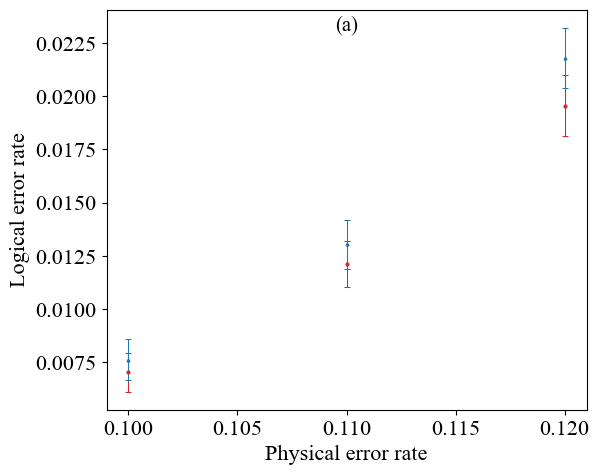

In [3]:
# Repetition code with circuit level noise, qubits number : 33=17+16

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
plt.rc('font', family='Times New Roman')
matplotlib.rcParams['font.size'] = 16

font = {'family':'Times New Roman'  #'serif', 
#         ,'style':'italic'
        ,'weight':'normal'  # 'normal' 
#         ,'color':'red'
        ,'size':16
       }
font1 = {'family':'Times New Roman'  #'serif', 
#         ,'style':'italic'
        ,'weight':'normal'  # 'normal' 
#         ,'color':'red'
        ,'size':13
       }


# gnd = np.array([0.007053, 0.012067, 0.0194  ])
# mw = np.array([0.007592, 0.013032, 0.021796])

# gnd_std = np.array([0.00082091, 0.00107917, 0.00132197])
# mw_std = np.array([0.00079695, 0.00112933, 0.00133146])

print('relative improvment (%):', (mw-gnd)/mw)
fig = plt.figure(dpi=100, figsize=(6,5))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
ax.text(0.5, 0.95, '(a)', size=15, transform=ax.transAxes, ha="center")

ers = np.linspace(0.1, 0.12, 3)

ax.errorbar(x=ers, y=gnd, yerr=gndstd, fmt='o', linewidth=0.5, ecolor='tab:red', color='tab:red', capsize=2, capthick=0.75, elinewidth=0.75, label='GND', ms=2)

ax.errorbar(x=ers, y=mw, yerr=mwstd, fmt='^', linewidth=0.5, ecolor='tab:blue', color='tab:blue', capsize=2, capthick=0.75, elinewidth=0.75, label='MWPM', ms=2)


ax.set_xlabel('Physical error rate' , font)
ax.set_ylabel('Logical error rate', font)
plt.show()


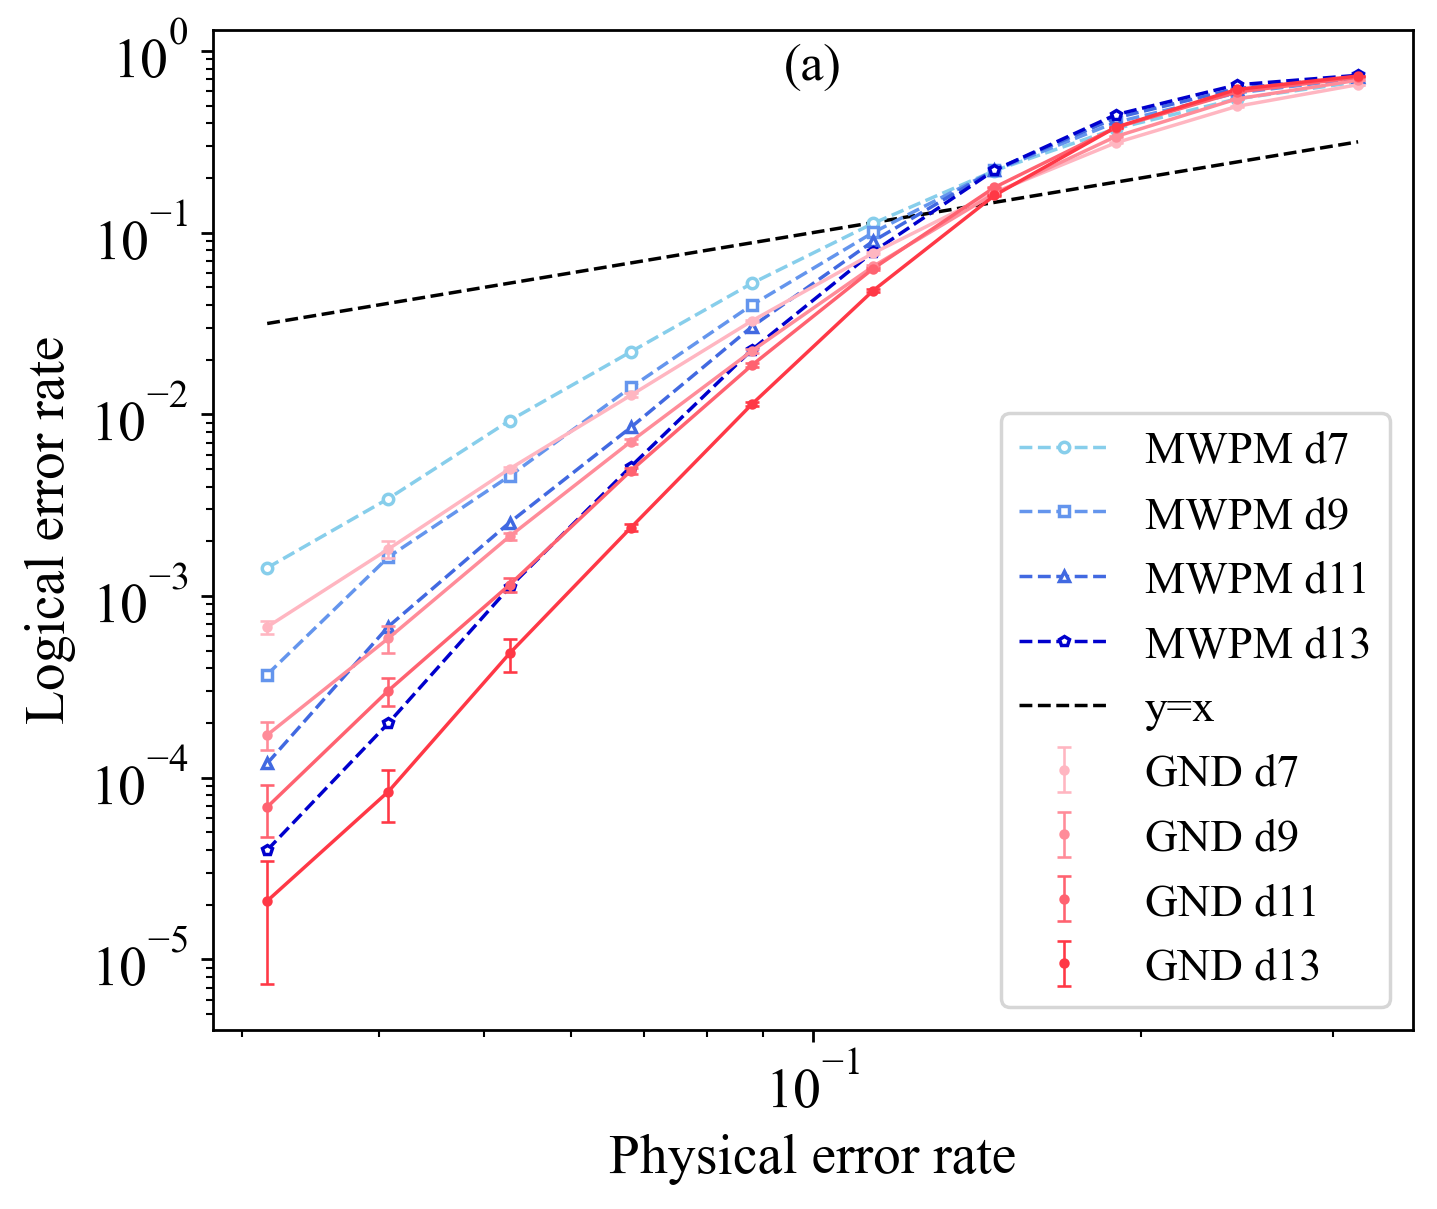

In [ ]:

import torch
import matplotlib.pyplot as plt
import matplotlib
plt.rc('font', family='Times New Roman')
matplotlib.rcParams['font.size'] = 16

font = {'family':'Times New Roman'  #'serif', 
#         ,'style':'italic'
        ,'weight':'normal'  # 'normal' 
#         ,'color':'red'
        ,'size':16
       }
font1 = {'family':'Times New Roman'  #'serif', 
#         ,'style':'italic'
        ,'weight':'normal'  # 'normal' 
#         ,'color':'red'
        ,'size':13
       }

import torch
import matplotlib.pyplot as plt
error_rate = torch.logspace(-1.5, -0.5, 10)

mw13=[4.0000000000040004e-05, 0.00019999999999997797, 0.0011200000000000099, 0.005160000000000053, 0.022730000000000028, 0.07847000000000004, 0.22068, 0.44559000000000004, 0.65084, 0.73489]
GN13=[2.1000000000000002e-05, 8.400000000000001e-05, 0.00048400000000000006, 0.002377, 0.011394000000000001, 0.04804900000000001, 0.160275, 0.379892, 0.614175, 0.7280249999999999]#[2e-05, 0.00011, 0.00038, 0.00218, 0.01182, 0.047080000000000004, 0.15948, 0.37942000000000004, 0.61294, 0.72372]
mw11=[0.00012000000000000899, 0.0006800000000000139, 0.0025399999999999867, 0.008480000000000043, 0.030410000000000048, 0.08987, 0.22163, 0.42804, 0.62111, 0.72306]
GN11=[6.900000000000001e-05, 0.000302, 0.001154, 0.0048920000000000005, 0.018672, 0.063473, 0.177409, 0.37865200000000004, 0.594154, 0.7165900000000001]#[0.00011, 0.00029, 0.00141, 0.0048200000000000005, 0.018690000000000002, 0.063, 0.17600000000000002, 0.37887000000000004, 0.5974, 0.71833]
mw9=[0.00036999999999998145, 0.0016399999999999748, 0.0045800000000000285, 0.014070000000000027, 0.04003000000000001, 0.10026000000000002, 0.21997999999999995, 0.40435, 0.58731, 0.70557]
GN9=[0.000172, 0.000586, 0.002132, 0.007082, 0.022365000000000003, 0.06528400000000001, 0.16420300000000004, 0.337847, 0.544637, 0.690621]#[0.00024000000000000003, 0.00072, 0.00202, 0.007330000000000001, 0.02288, 0.06430000000000001, 0.1647, 0.33889, 0.5439700000000001, 0.6917500000000001]
mw7=[0.0014300000000000423, 0.0034399999999999986, 0.009240000000000026, 0.022090000000000054, 0.052669999999999995, 0.11258000000000001, 0.21935000000000004, 0.37343000000000004, 0.54494, 0.6756599999999999]
GN7=[0.000676, 0.001814, 0.005015, 0.012737000000000002, 0.03273600000000001, 0.077178, 0.16632600000000003, 0.31222300000000003, 0.49572099999999997, 0.652579]

std7=[5.6608e-05, 0.0002, 0.0001, 0.0003, 0.0005, 0.0010, 0.0010, 0.0014, 0.0016, 0.0010]
std9=[3.0111e-05, 0.0001, 0.0001, 0.0002, 0.0005, 0.0009, 0.0009, 0.0010, 0.0014, 0.0018]
std11=[2.1833e-05, 5.2504e-05, 0.0001, 0.0002, 0.0005, 0.0008, 0.0012, 0.0015, 0.0015, 0.0010]
std13=[1.3703e-05, 2.6750e-05, 0.0001, 0.0001, 0.0003, 0.0009, 0.0010, 0.0014, 0.0017, 0.0021]

fig = plt.figure(dpi=250, figsize=(6,5))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
ax.text(0.5, 0.95, '(a)', size=15, transform=ax.transAxes, ha="center")



colors1 = ['#87CEEB', '#6495ED', '#4169E1', '#0000CD', '#000080']#'#87CEEB', 
colors = ['#FFB6C1', '#FF8C99', '#FF6270', '#FF3846', '#FF0E1D']#'#FFB6C1'

ax.plot(error_rate, mw7, linewidth=1, marker='o', markersize=3, mfc='w', label='MWPM d7', linestyle='--', c=colors1[0], zorder=1)
ax.errorbar(x=error_rate, y=GN7, yerr=std7, fmt='o', linewidth=0.5, ecolor=colors[0], color=colors[0], capsize=2, capthick=0.75, elinewidth=0.75, label='GND d7', ms=2, zorder=2)
ax.plot(error_rate, GN7, linewidth=1, c=colors[0])
ax.plot(error_rate, mw9, linewidth=1, marker='s', markersize=3, mfc='w', label='MWPM d9', linestyle='--', c=colors1[1], zorder=1)
ax.errorbar(x=error_rate, y=GN9, yerr=std9, fmt='o', linewidth=0.5, ecolor=colors[1], color=colors[1], capsize=2, capthick=0.75, elinewidth=0.75, label='GND d9', ms=2)
ax.plot(error_rate, GN9, linewidth=1, c=colors[1])
ax.plot(error_rate, mw11, linewidth=1, marker='^', markersize=3, mfc='w', label='MWPM d11', linestyle='--', c=colors1[2], zorder=1)
ax.errorbar(x=error_rate, y=GN11, yerr=std11, fmt='o', linewidth=0.5, ecolor=colors[2], color=colors[2], capsize=2, capthick=0.75, elinewidth=0.75, label='GND d11', ms=2)
ax.plot(error_rate, GN11, linewidth=1, c=colors[2])
ax.plot(error_rate, mw13, linewidth=1, marker='p', markersize=3, mfc='w', label='MWPM d13', linestyle='--', c=colors1[3], zorder=1)
ax.errorbar(x=error_rate, y=GN13, yerr=std13, fmt='o', linewidth=0.5, ecolor=colors[3], color=colors[3], capsize=2, capthick=0.75, elinewidth=0.75, label='GND d13', ms=2)
ax.plot(error_rate, GN13, linewidth=1, c=colors[3])

ax.plot(error_rate, error_rate, linewidth=1, linestyle='--', c='k', label='y=x',zorder=0)

ax.set_xlabel('Physical error rate' , font)
ax.set_ylabel('Logical error rate', font)
# plt.xticks(fontsize=(12))
# plt.yticks(fontsize=(12))
plt.yscale('log')
plt.xscale('log')
plt.legend(prop=font1)
# plt.savefig('/data/caohanyan/qecGPT/fig/rsc1.pdf', bbox_inches = 'tight')
plt.show()


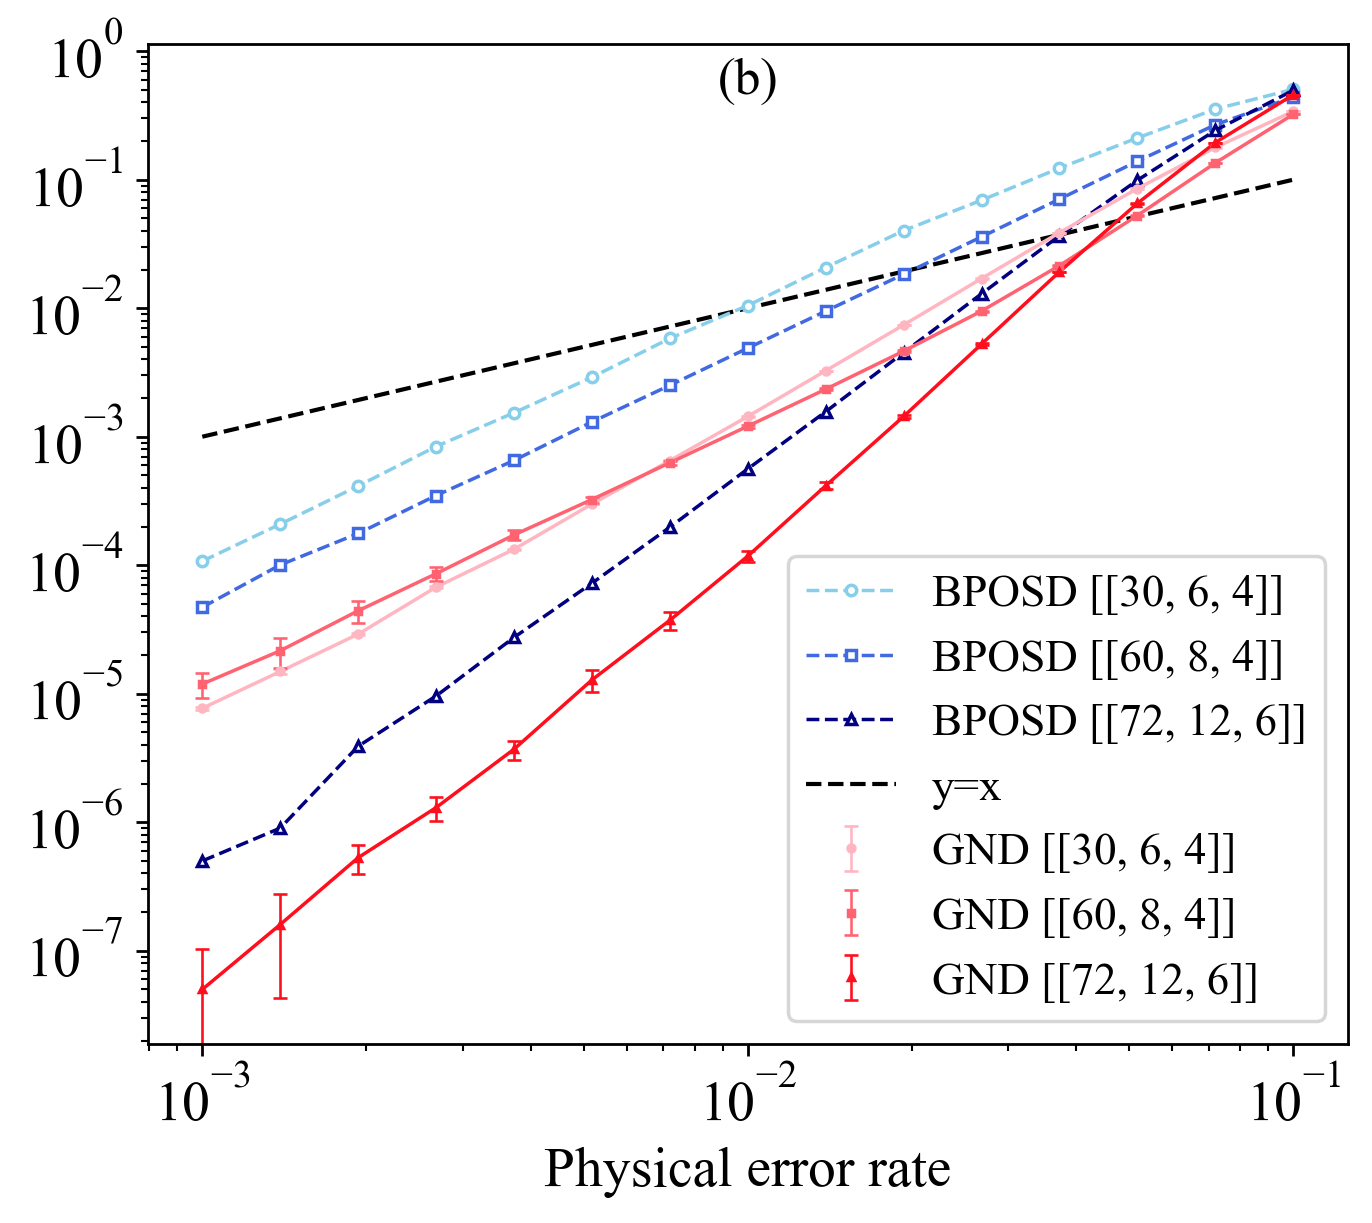

In [2]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import matplotlib
plt.rc('font', family='Times New Roman')
matplotlib.rcParams['font.size'] = 16

font = {'family':'Times New Roman'  #'serif', 
#         ,'style':'italic'
        ,'weight':'normal'  # 'normal' 
#         ,'color':'red'
        ,'size':16
       }
font1 = {'family':'Times New Roman'  #'serif', 
#         ,'style':'italic'
        ,'weight':'normal'  # 'normal' 
#         ,'color':'red'
        ,'size':13
       }

error_rate = torch.logspace(-3, -1, 15)
bposd4k6 = [0.00010750000000003812,0.00020880000000000898,0.00041349999999995557,0.00083869999999997,0.001534999999999953,0.002903300000000053,0.005815400000000026,0.010484700000000013,0.020725100000000052,0.040158999999999945,0.06921659999999996,0.1229439,0.2111883,0.3538184, 0.5053099999999999]
d4k6 = np.array([7.7e-07, 1.49e-06, 2.9100000000000005e-06, 6.75e-06, 1.3310000000000003e-05, 2.992e-05, 6.512e-05, 0.00014370000000000002, 0.00032603, 0.0007406, 0.0017013300000000002, 0.0038715900000000003, 0.008519370000000002, 0.017801660000000004, 0.0339821])*10#[0.0012200000000000002, 0.0029000000000000002, 0.005840000000000001, 0.0117, 0.02363, 0.047650000000000005, 0.09375000000000001, 0.17607, 0.30923, 0.49601000000000006]
std30 = [2.213594362117866e-07, 5.743595467030117e-07, 7.030884249746499e-07, 9.68676072448026e-07, 9.29097531060234e-07, 1.1688550903436333e-06, 2.9423346739168434e-06, 3.177350398611329e-06, 5.99426577841042e-06, 6.246421197596085e-06, 1.5143539143072853e-05, 2.319633352253946e-05, 2.6813680173456968e-05, 3.30987814478623e-05, 4.536618907414303e-05]


bposdn60k8 = [4.709999999996661e-05, 0.00010049999999994785, 0.0001767000000000296, 0.0003486000000000322, 0.0006540999999999908, 0.0013031000000000015, 0.0025115, 0.004887799999999998, 0.009491499999999986, 0.018362300000000054, 0.035907400000000034, 0.07058719999999996, 0.13908779999999998, 0.267471, 0.4396]
bposdn72k12 = [4.999999999588667e-07,8.999999999703689e-07,3.899999999945614e-06,9.60000000005401e-06,2.740000000001075e-05,7.239999999997249e-05,0.00019760000000001998,0.0005614999999999926,0.001565099999999986,0.004514200000000024,0.012945600000000002,0.036606099999999975,0.0989509,0.2416022, 0.495699]#[0.00019999999999997797, 0.00649999999999995, 0.031100000000000017, 0.07730000000000004, 0.15000000000000002, 0.24980000000000002, 0.3577, 0.48829999999999996, 0.5933999999999999, 0.6817, 0.7725, 0.8411, 0.8901, 0.9234, 0.9529, 0.9708, 0.9832, 0.9897, 0.9937, 1.0]



n60k8 = np.array([1.19e-06, 2.1600000000000005e-06, 4.42e-06, 8.59e-06, 1.72e-05, 3.246000000000001e-05, 6.272000000000001e-05, 0.00012072000000000001, 0.00023418, 0.00046319000000000004, 0.00094937, 0.00214431, 0.005260170000000001, 0.013496820000000001, 0.03222477])*10#[0.0013100000000000002, 0.00236, 0.00369, 0.006520000000000001, 0.013620000000000002, 0.02688, 0.058850000000000006, 0.13302, 0.28472000000000003, 0.52986]
n72k12 = np.array([5.000000000000001e-09, 1.6e-08, 5.3e-08, 1.3e-07, 3.7000000000000006e-07, 1.28e-06, 3.7300000000000007e-06, 1.177e-05, 4.152e-05, 0.00014376, 0.0005254400000000001, 0.0019190500000000003, 0.00654122, 0.01942754, 0.04572806])*10#[0.0001, 0.00032, 0.00107, 0.00301, 0.00944, 0.0274, 0.07622000000000001, 0.19172000000000003, 0.40687, 0.68954]#[0.0001, 0.0018000000000000002, 0.013900000000000001, 0.049100000000000005, 0.1042, 0.1976, 0.3123, 0.44060000000000005, 0.5627, 0.6763, 0.7638, 0.8382000000000001, 0.8885000000000001, 0.9258000000000001, 0.9538000000000001, 0.9702000000000001, 0.9807, 0.9897, 0.9944000000000001, 0.9963000000000001]

std60=np.array([2.601281735350223e-07, 5.621387729022078e-07, 8.443274772793367e-07, 1.013738953906116e-06, 1.5740958604156807e-06, 1.7689921801221546e-06, 2.5441872747281975e-06, 3.246468166416484e-06, 4.407266726668576e-06, 7.2836880157727275e-06, 8.697387858176503e-06, 1.7007282753769432e-05, 1.9733673983546415e-05, 3.4930845967426074e-05, 6.186162066347058e-05])*10
std72=np.array([5.2704627669472995e-09, 1.1737877907772675e-08, 1.3374935098492588e-08, 2.8304589153964794e-08, 6.2516655570345726e-08, 2.573367875415838e-07, 6.201254353399446e-07, 1.125512229066294e-06, 2.5297342855635165e-06, 4.08199297729267e-06, 8.569740045324861e-06, 1.0467011671596259e-05, 2.1170566569860132e-05, 3.546867788783759e-05, 4.2833948114914197e-05])*10

# fig = plt.figure(dpi=250, figsize=(5,5))
# ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])

fig = plt.figure(dpi=250, figsize=(6,5))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
# print(bposdn72k12[a])
# print(bposdn144k12[a])

ax.text(0.5, 0.95, '(b)', size=15, transform=ax.transAxes, ha="center")

colors1 = ['#87CEEB', '#6495ED', '#4169E1', '#0000CD', '#000080']
colors = ['#FFB6C1', '#FF8C99', '#FF6270', '#FF3846', '#FF0E1D']

ax.plot(error_rate, bposd4k6, linewidth=1, label='BPOSD [[30, 6, 4]]', linestyle='--', c=colors1[0], zorder=1, marker='o', markersize=3, mfc='w')#, marker='o', markersize=4, mfc='w', 
ax.errorbar(x=error_rate, y=d4k6, yerr=std30, fmt='o', linewidth=0.5, ecolor=colors[0], color=colors[0], capsize=2, capthick=0.75, elinewidth=0.75, label='GND [[30, 6, 4]]', ms=2)
ax.plot(error_rate, d4k6, linewidth=1, c=colors[0])
ax.plot(error_rate, bposdn60k8, linewidth=1, label='BPOSD [[60, 8, 4]]', linestyle='--', c=colors1[2], zorder=1, marker='s', markersize=3, mfc='w')
ax.errorbar(x=error_rate, y=n60k8, yerr=std60, fmt='s', linewidth=0.5, ecolor=colors[2], color=colors[2], capsize=2, capthick=0.75, elinewidth=0.75, label='GND [[60, 8, 4]]', ms=2)
ax.plot(error_rate, n60k8, linewidth=1, c=colors[2])
ax.plot(error_rate, bposdn72k12, linewidth=1, label='BPOSD [[72, 12, 6]]', linestyle='--', c=colors1[4], zorder=1, marker='^', markersize=3, mfc='w')
ax.errorbar(x=error_rate, y=n72k12, yerr=std72, fmt='^', linewidth=0.5, ecolor=colors[4], color=colors[4], capsize=2, capthick=0.75, elinewidth=0.75, label='GND [[72, 12, 6]]', ms=2)
ax.plot(error_rate, n72k12, linewidth=1, c=colors[4])

#background-image: linear-gradient(to right, #2000ff, #b300c0, #d60089, #da0563, #cd5252);



ax.plot(error_rate, error_rate, linewidth=1.2, linestyle='--', c='k', label='y=x', zorder=0)
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('Physical error rate', font)# $\epsilon$
# ax.set_ylabel('Logical error rate', font)
plt.legend(prop=font1)
# plt.xticks(fontsize=(12))
# plt.yticks(fontsize=(12))
# plt.savefig('/data/caohanyan/qecGPT/fig/high_rate.pdf', bbox_inches = 'tight')
plt.show()

# print(n90k8)

In [7]:
print((bposdn72k12[0]-n72k12[0])/bposdn72k12[0])
print((bposdn60k8[0]-n60k8[0])/bposdn60k8[0])

0.8999999999917734
0.7473460721866573


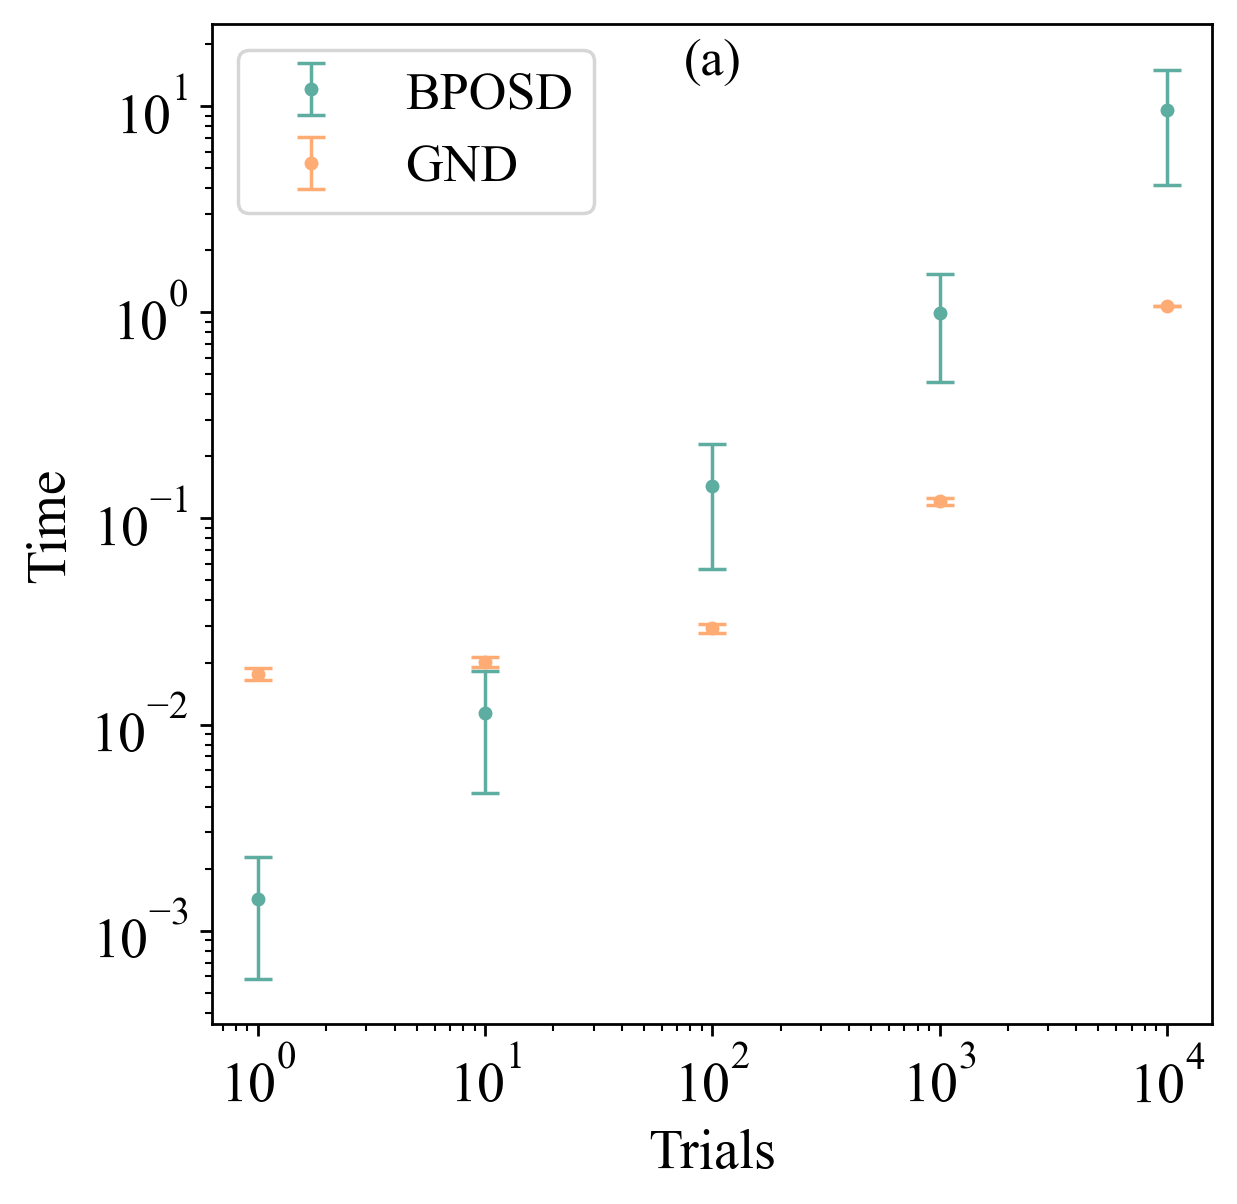

In [4]:
font = {'family':'Times New Roman'  #'serif', 
#         ,'style':'italic'
        ,'weight':'normal'  # 'normal' 
#         ,'color':'red'
        ,'size':16
       }

font1 = {'family':'Times New Roman'  #'serif', 
#         ,'style':'italic'
        ,'weight':'normal'  # 'normal' 
#         ,'color':'red'
        ,'size':15
       }
import torch
import matplotlib.pyplot as plt
import matplotlib
plt.rc('font', family='Times New Roman')
matplotlib.rcParams['font.size'] = 16
x = [1, 10, 100, 1000, 10000]

tbp = [0.001425645351409912, 0.011427688598632812, 0.14311494827270507, 0.996195650100708, 9.615233635902404]
tbpe = [0.0008406566270224099, 0.00678410714585703, 0.08595554242116014, 0.5356494685979603, 5.448544468864959]
tours = [0.01763765811920166, 0.020078873634338378, 0.029271650314331054, 0.12088072299957275, 1.0751774549484252]
tourse = [0.0011173419891314187, 0.0011385632832339957, 0.001461531441987036, 0.004459155672963291, 0.0029853836920323918]

fig = plt.figure(dpi=250, figsize=(5,5))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
ax.text(0.5, 0.95, '(a)', size=15, transform=ax.transAxes, ha="center")
ax.errorbar(x, tbp, yerr=tbpe, fmt='o', ecolor='#5DADA0', color='#5DADA0', elinewidth=1, capsize=4, ms=3, label='BPOSD')
ax.errorbar(x, tours, yerr=tourse, fmt='o', ecolor='#FFAB74', color='#FFAB74', elinewidth=1, capsize=4, ms=3, label='GND')


ax.set_xlabel('Trials', font)
ax.set_ylabel('Time', font)
plt.yscale('log')
plt.xscale('log')

plt.legend(prop=font1)
# plt.savefig('/data/caohanyan/qecGPT/fig/time1.pdf', bbox_inches = 'tight')
plt.show()


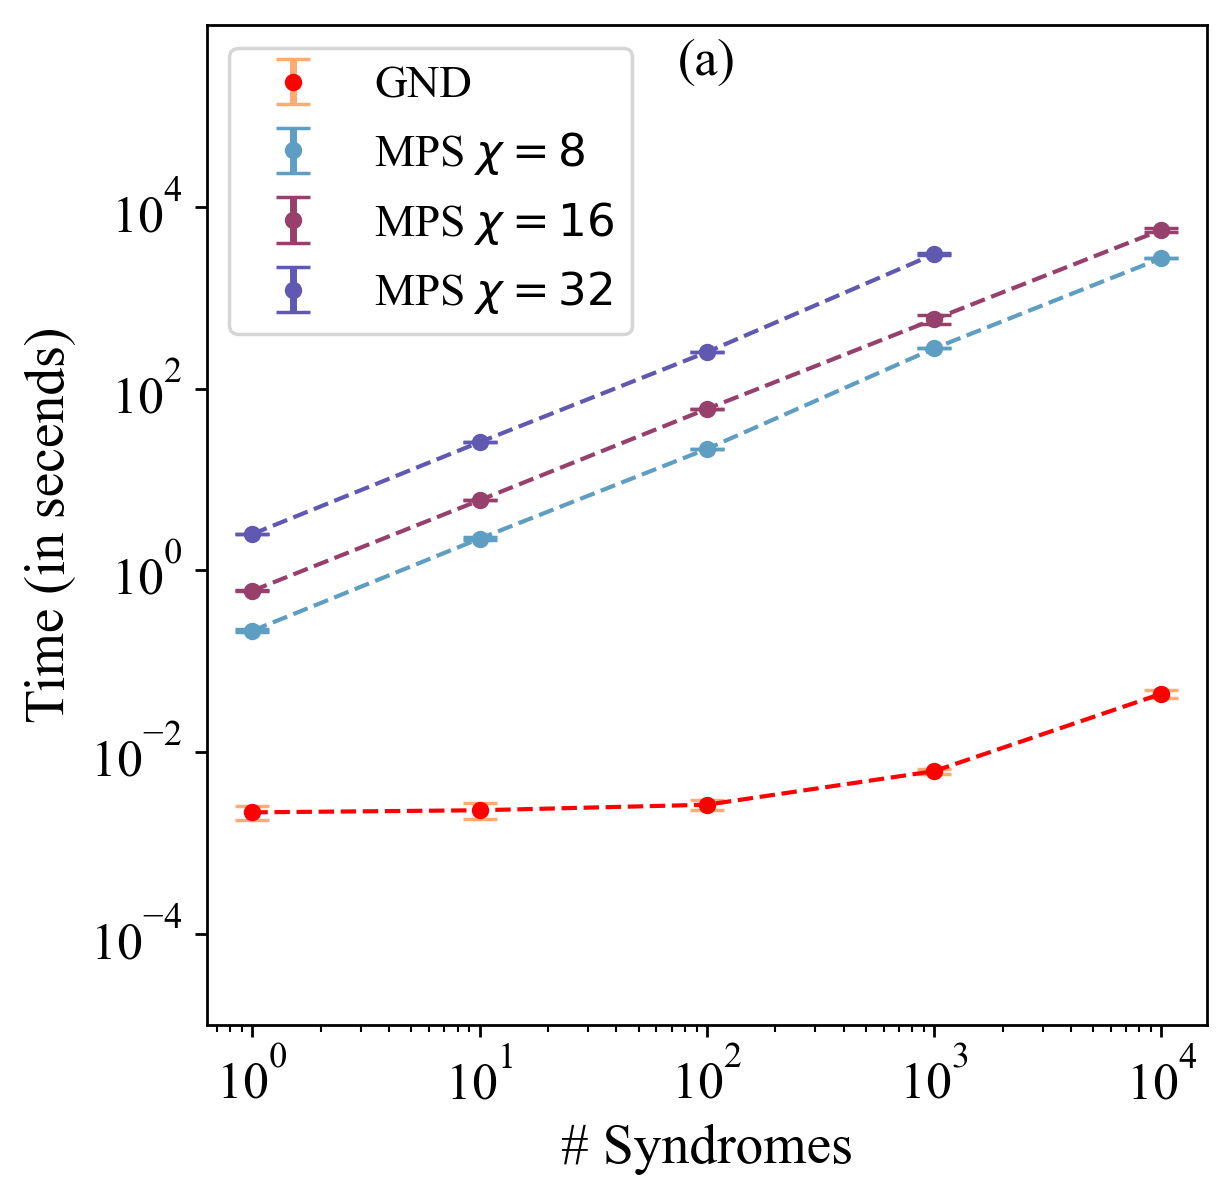

In [3]:
import numpy as np
font = {'family':'Times New Roman'  #'serif', 
#         ,'style':'italic'
        ,'weight':'normal'  # 'normal' 
#         ,'color':'red'
        ,'size':16
       }

font1 = {'family':'Times New Roman'  #'serif', 
#         ,'style':'italic'
        ,'weight':'normal'  # 'normal' 
#         ,'color':'red'
        ,'size':13
       }
import torch
import matplotlib.pyplot as plt
import matplotlib
plt.rc('font', family='Times New Roman')
matplotlib.rcParams['font.size'] = 16
x = [1, 10, 100, 1000, 10000]
x1 = [1, 10, 100, 1000]

tMW = [3.3957719802856446e-05, 0.0006553411483764648, 0.0035515546798706053, 0.028092050552368165, 0.2638955354690552]
tMWe = [8.939843133516817e-06, 5.129110269653039e-05, 0.0010048700803973216, 0.007408250187013047, 0.05220506197907798]
tours = [0.0021841049194335936, 0.002301812171936035, 0.0026484251022338865, 0.006201648712158203, 0.04402270317077637]
tourse = [0.0003843455690409078, 0.00044522170313441705, 0.00034900178644995295, 0.00037839131195703497, 0.004520805816758768]

tnchi8 = [0.2172416958808899, 2.2400888204574585, 21.72416958808899, 277.2309293270111, 2724.4207770824432]
tnchi8e = [0.00763716382227547, 0.08337006133235274, 0.14906069414328738, 0.5365353218692207, 8.695009489311756]

tnchi16 = [0.5980507895946503, 5.920920085906983, 59.80507895946503, 579.7006694078445, 5573.344551873207 ]
tnchi16e = [0.00958236154272331, 0.018355199257283555, 0.3541540115387204, 61.559597024839654, 305.29393194929435]

tnchi32 = [2.5180507895946503, 25.77659800052643, 252.31647918224334, 3019.4456471681597]
tnchi32e = [0.01958236154272331, 0.18355199257283555, 1.871565587657198, 52.819829608217475]



fig = plt.figure(dpi=250, figsize=(5,5))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
ax.text(0.5, 0.95, '(a)', size=15, transform=ax.transAxes, ha="center")
# ax.errorbar(x, tMW, yerr=tMWe, fmt='o', ecolor='#6058B1', color='#6058B1', elinewidth=1, capsize=4, ms=3, label='MWPM slope$=%.3f$'%kb0[0])
ax.errorbar(x, tours, yerr=tourse, fmt='o', ecolor='#FFAB74', color='red', elinewidth=2, capsize=5, ms=4, label='GND')
ax.errorbar(x, tnchi8, yerr=tnchi8e, fmt='o', ecolor='#5E9EC2', color='#5E9EC2', elinewidth=2, capsize=5, ms=4, label='MPS $\chi=8$')
ax.errorbar(x, tnchi16, yerr=tnchi16e, fmt='o', ecolor='#97406B', color='#97406B', elinewidth=2, capsize=5, ms=4, label='MPS $\chi=16$')
ax.errorbar(x1, tnchi32, yerr=tnchi32e, fmt='o', ecolor='#6058B1', color='#6058B1', elinewidth=2, capsize=5, ms=4, label='MPS $\chi=32$')





ax.plot(x, tnchi8, linestyle='--', linewidth=1.2, color='#5E9EC2')
ax.plot(x,tnchi16, linestyle='--', linewidth=1.2, color='#97406B')
ax.plot(x1, tnchi32, linestyle='--', linewidth=1.2, color='#6058B1')
ax.plot(x, tours, linestyle='--', linewidth=1.2, color='red')

ax.set_xlabel('# Syndromes', font)
ax.set_ylabel('Time (in secends)', font)
plt.yscale('log')
plt.xscale('log')
plt.xticks(fontsize=(15))
plt.yticks([10**i for i in range(-4, 5, 2)], fontsize=15)
plt.ylim(1e-5, 1e6)
plt.legend(prop=font1, loc= 'upper left')
# plt.savefig('/data/caohanyan/qecGPT/fig/time2.pdf', bbox_inches = 'tight')
plt.show()